In [47]:
# Import the libraries
import math
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [48]:
#Reading the dataset and selecting the required attributimport pandas as pd
import numpy as np
#Pre-processing the dataset

#Read the virtual dataset
data=pd.read_csv("input/Apartment_3.csv")

#Extract the necessary fields
for col in list(data):
    if col not in ['date_time','power']:
        data=data.drop(col,1)

#Saving the processed dataset
data.to_csv('building_data.csv',index=False)

In [49]:
data.head(10)

,date_time,power
0,14/12/16 15:30,225.867819
1,14/12/16 16:30,192.269673
2,14/12/16 17:30,189.568503
3,14/12/16 18:30,121.428990
4,14/12/16 19:30,118.425923
5,14/12/16 20:30,94.055131
6,14/12/16 21:30,61.682062
7,14/12/16 22:30,63.277373
8,14/12/16 23:30,87.277348
9,15/12/16 0:30,138.641448


In [50]:
data.shape

(4489, 2)

In [51]:
df = data.set_index('date_time')
df.head()

,power
date_time,
14/12/16 15:30,225.867819
14/12/16 16:30,192.269673
14/12/16 17:30,189.568503
14/12/16 18:30,121.428990
14/12/16 19:30,118.425923


In [52]:
df.to_csv('cleaned_data.csv')
dataset = pd.read_csv('cleaned_data.csv', parse_dates = True, index_col = 'date_time')
dataset.head(10)

,power
date_time,
2016-12-14 15:30:00,225.867819
2016-12-14 16:30:00,192.269673
2016-12-14 17:30:00,189.568503
2016-12-14 18:30:00,121.428990
2016-12-14 19:30:00,118.425923
2016-12-14 20:30:00,94.055131
2016-12-14 21:30:00,61.682062
2016-12-14 22:30:00,63.277373
2016-12-14 23:30:00,87.277348


In [53]:
dataset.tail()

,power
date_time,
2017-12-26 19:30:00,72.754952
2017-12-26 20:30:00,147.190380
2017-12-26 21:30:00,140.709746
2017-12-26 22:30:00,79.923904
2017-12-26 23:30:00,62.734310


In [54]:
power_data = dataset.resample('D').sum()
power_data.head(10)

,power
date_time,
2016-12-14,1153.852824
2016-12-15,3256.450538
2016-12-16,1242.915919
2016-12-17,0.000000
2016-12-18,0.000000
2016-12-19,2355.161530
2016-12-20,4771.486282
2016-12-21,2185.122440
2016-12-22,3209.763329


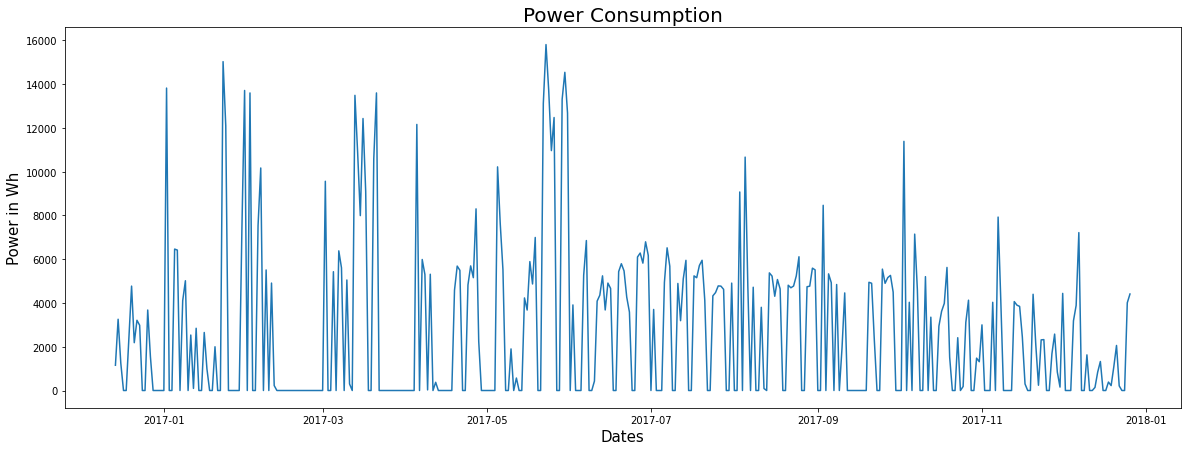

In [55]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)
plt.xlabel('Dates',fontsize=15)
plt.ylabel('Power in Wh',fontsize=15)
plt.title('Power Consumption',fontsize=20)
plt.plot(power_data)
plt.savefig("figure1.png")

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
power_data = scaler.fit_transform(np.array(power_data).reshape(-1,1))

In [57]:
# Splitting the data into test and train split
training_size = int(len(power_data)*0.80)
test_size = len(power_data)-training_size
train_data, test_data = power_data[0:training_size,:],power_data[training_size:len(power_data),:1]

In [58]:
training_size,test_size

(302, 76)

In [59]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(power_dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(power_dataset)-time_step-1):
		a = power_dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3----20
		dataX.append(a)
		dataY.append(power_dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [60]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [61]:
print(X_train.shape), print(y_train.shape)

(281, 20)
(281,)


(None, None)

In [62]:
print(X_test.shape), print(ytest.shape)

(55, 20)
(55,)


(None, None)

In [63]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [64]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [65]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(20,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=400,batch_size=64,verbose=1)

Epoch 1/400
5/5 [==============================] - 8s 435ms/step - loss: 0.0802 - val_loss: 0.0201
Epoch 2/400
5/5 [==============================] - 0s 82ms/step - loss: 0.0614 - val_loss: 0.0206
Epoch 3/400
5/5 [==============================] - 0s 64ms/step - loss: 0.0595 - val_loss: 0.0178
Epoch 4/400
5/5 [==============================] - 0s 60ms/step - loss: 0.0602 - val_loss: 0.0181
Epoch 5/400
5/5 [==============================] - 0s 67ms/step - loss: 0.0589 - val_loss: 0.0235
Epoch 6/400
5/5 [==============================] - 0s 59ms/step - loss: 0.0590 - val_loss: 0.0223
Epoch 7/400
5/5 [==============================] - 0s 61ms/step - loss: 0.0589 - val_loss: 0.0192
Epoch 8/400
5/5 [==============================] - 0s 53ms/step - loss: 0.0586 - val_loss: 0.0227
Epoch 9/400
5/5 [==============================] - 0s 56ms/step - loss: 0.0582 - val_loss: 0.0228
Epoch 10/400
5/5 [==============================] - 0s 56ms/step - loss: 0.0581 - val_loss: 0.0206
Epoch 11/400
5/5 [

In [68]:
import tensorflow as tf

In [69]:
# Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [70]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [71]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(ytest,test_predict))

3827.127705488192

In [72]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

3827.127705488192

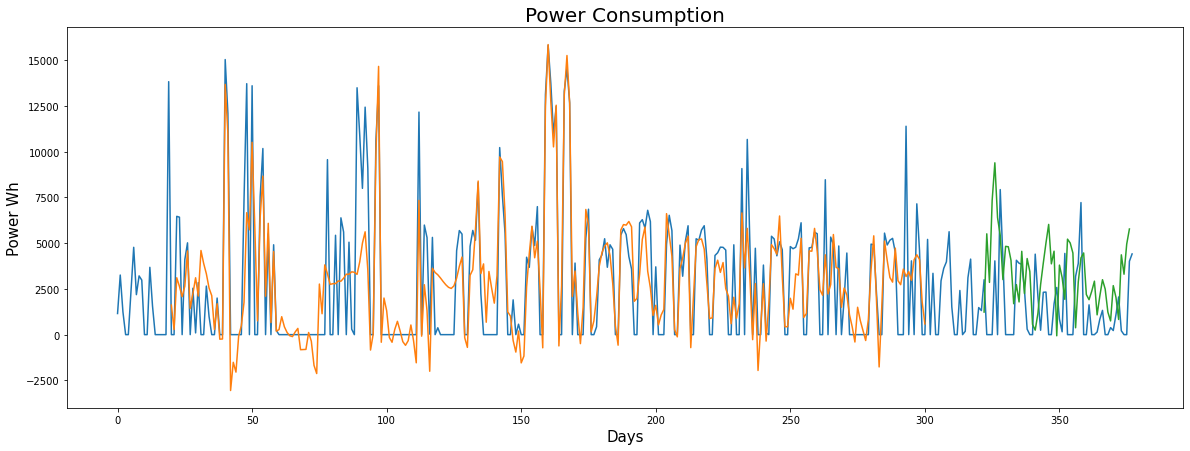

In [73]:
# Plotting 
# Shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(power_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(power_data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(power_data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(power_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Power Wh',fontsize=15)
plt.title('Power Consumption',fontsize=20)
plt.savefig("figure2.png")
plt.show()

In [74]:
trainPredictPlot.shape

(378, 1)

In [75]:
len(test_data)

76

In [76]:
x_input=test_data[56:].reshape(1,-1)
x_input.shape

(1, 20)

In [77]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [78]:
temp_input

[0.4564602100849,
 0.0,
 0.0,
 0.10300175061744073,
 0.0,
 0.0,
 0.00899127853585016,
 0.05310759039541199,
 0.0838495171896245,
 0.0,
 0.0,
 0.024376269759991298,
 0.014214664345251165,
 0.06896691310151903,
 0.13021254910179983,
 0.013344349633201255,
 0.0,
 0.0,
 0.25361240708052557,
 0.27894895792067864]

In [79]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=20
i=0
while(i<30):
    
    if(len(temp_input)>20):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.07138341]
21
1 day input [0.         0.         0.10300175 0.         0.         0.00899128
 0.05310759 0.08384952 0.         0.         0.02437627 0.01421466
 0.06896691 0.13021255 0.01334435 0.         0.         0.25361241
 0.27894896 0.07138341]
1 day output [[0.22941448]]
2 day input [0.         0.10300175 0.         0.         0.00899128 0.05310759
 0.08384952 0.         0.         0.02437627 0.01421466 0.06896691
 0.13021255 0.01334435 0.         0.         0.25361241 0.27894896
 0.07138341 0.22941448]
2 day output [[0.24878275]]
3 day input [0.10300175 0.         0.         0.00899128 0.05310759 0.08384952
 0.         0.         0.02437627 0.01421466 0.06896691 0.13021255
 0.01334435 0.         0.         0.25361241 0.27894896 0.07138341
 0.22941448 0.24878275]
3 day output [[0.26839852]]
4 day input [0.         0.         0.00899128 0.05310759 0.08384952 0.
 0.         0.02437627 0.01421466 0.06896691 0.13021255 0.01334435
 0.         0.         0.25361241 0.27894896 0.0713

In [80]:
day_new=np.arange(1,21)
day_pred=np.arange(21,51)

In [81]:
import matplotlib.pyplot as plt

In [82]:
prev_day = scaler.inverse_transform(power_data[358:])
next_few = scaler.inverse_transform(lst_output)

In [83]:
new_day = day_new.tolist()
pred_day = day_pred.tolist()

In [84]:
new_day

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [85]:
previous =  prev_day.tolist()
nextday = next_few.tolist()
flat_prev = []
for item in previous:
    flat_prev.extend(item)
flat_previous = [round(num,2)for num in flat_prev]
flat_next= []
for item in nextday:
    flat_next.extend(item)
flat_nextday = [round(num,2)for num in flat_next]

In [86]:
result1 = pd.DataFrame(zip(new_day,flat_previous),columns =['day', 'value'])
result2 = pd.DataFrame(zip(pred_day,flat_nextday),columns =['day', 'value'])

result_prev = result1.to_json(orient="records")
result_previous = json.loads(result_prev)

result_next = result2.to_json(orient="records")
result_nextday = json.loads(result_next)
result_previous

[{'day': 1, 'value': 7216.52},
 {'day': 2, 'value': 0.0},
 {'day': 3, 'value': 0.0},
 {'day': 4, 'value': 1628.43},
 {'day': 5, 'value': 0.0},
 {'day': 6, 'value': 0.0},
 {'day': 7, 'value': 142.15},
 {'day': 8, 'value': 839.62},
 {'day': 9, 'value': 1325.64},
 {'day': 10, 'value': 0.0},
 {'day': 11, 'value': 0.0},
 {'day': 12, 'value': 385.38},
 {'day': 13, 'value': 224.73},
 {'day': 14, 'value': 1090.35},
 {'day': 15, 'value': 2058.63},
 {'day': 16, 'value': 210.97},
 {'day': 17, 'value': 0.0},
 {'day': 18, 'value': 0.0},
 {'day': 19, 'value': 4009.55},
 {'day': 20, 'value': 4410.11}]

In [87]:
type(result_next)

str

In [88]:
type(result_nextday)

list

In [89]:
type(result_next)

str

In [90]:
# forecast_prev_data = zip(day_new.tolist(),flat_prev)
# forecast_prev_dict = dict(forecast_prev_data)

# forecast_next_data = zip(day_pred.tolist(),flat_next)
# forecast_next_dict = dict(forecast_next_data)

forecast_data = {'previous':result_previous,'next':result_nextday}
forecast_data

{'previous': [{'day': 1, 'value': 7216.52},
  {'day': 2, 'value': 0.0},
  {'day': 3, 'value': 0.0},
  {'day': 4, 'value': 1628.43},
  {'day': 5, 'value': 0.0},
  {'day': 6, 'value': 0.0},
  {'day': 7, 'value': 142.15},
  {'day': 8, 'value': 839.62},
  {'day': 9, 'value': 1325.64},
  {'day': 10, 'value': 0.0},
  {'day': 11, 'value': 0.0},
  {'day': 12, 'value': 385.38},
  {'day': 13, 'value': 224.73},
  {'day': 14, 'value': 1090.35},
  {'day': 15, 'value': 2058.63},
  {'day': 16, 'value': 210.97},
  {'day': 17, 'value': 0.0},
  {'day': 18, 'value': 0.0},
  {'day': 19, 'value': 4009.55},
  {'day': 20, 'value': 4410.11}],
 'next': [{'day': 21, 'value': 1128.55},
  {'day': 22, 'value': 3626.98},
  {'day': 23, 'value': 3933.19},
  {'day': 24, 'value': 4243.31},
  {'day': 25, 'value': 3924.58},
  {'day': 26, 'value': 4206.12},
  {'day': 27, 'value': 4437.39},
  {'day': 28, 'value': 4496.26},
  {'day': 29, 'value': 4397.21},
  {'day': 30, 'value': 4298.43},
  {'day': 31, 'value': 3991.09},
  

Text(0.5, 1.0, 'Power Consumption')

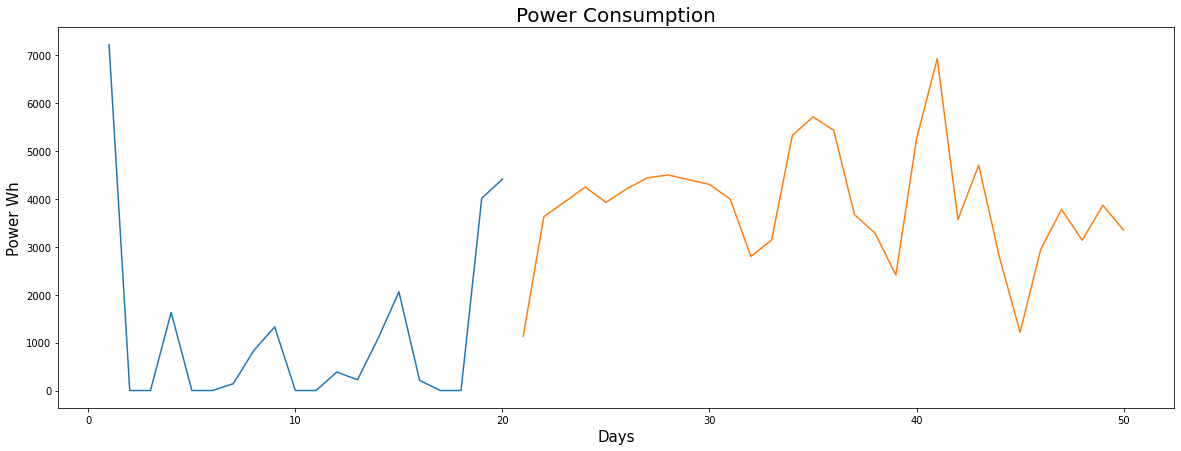

In [91]:
plt.plot(day_new,prev_day)
plt.plot(day_pred,next_few)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Power Wh',fontsize=15)
plt.savefig("figure3.png")
plt.title('Power Consumption',fontsize=20)

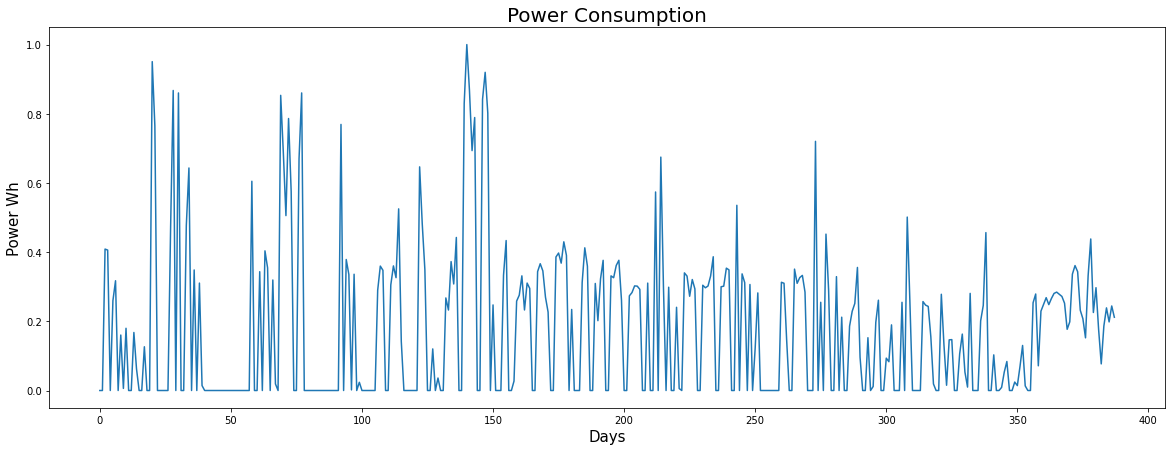

In [92]:
power_dt = power_data.tolist()
power_dt.extend(lst_output)
plt.plot(power_dt[20:])
plt.xlabel('Days',fontsize=15)
plt.ylabel('Power Wh',fontsize=15)
plt.title('Power Consumption',fontsize=20)
plt.savefig("figure4.png")
